In [20]:
# Imports for gplearn and pydotplus in order to see graph view

In [21]:
#tree viz
from IPython.display import Image
import pydotplus
#gplearn
from gplearn.genetic import SymbolicRegressor
from gplearn.fitness import make_fitness

#--Import the standard libraries--
import math
import random
import matplotlib.pyplot as plt
import numpy as np

#imports for bokeh
from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Range1d, LinearAxis

output_notebook()
 
#prints more verbose output
DEBUG = False
verbose_value = 0
if(DEBUG): verbose_value = 1

Loading BokehJS ...


# Read in test data

## format:

### details:

|#step  |#stride |
|-------|--------|

### training data:

|#rows  |1|
|-------|-|
|row1   | |
|row2   | |
|...    | |
|lastrow| |

Note, training data is also used as the test data in this case

In [22]:
#specfy folder/filename for data to be read in
folder = "data" 
filename = "testsine.mat"
filename_full = folder + "\\" +filename

#gets the step, str stride, hidden
def get_steps_stride():
    with open(filename_full, 'r') as file:
        line = file.readline()
        data_temp = list(map(int,line[::2]))
        #strip off the # of hidden nodes since we don't need
        data = tuple(data_temp[:2])
    return data

#returns a tuple of number of rows fortraining data
def get_num_rows():
    with open(filename_full, 'r') as file:
            lines = file.readlines()
            #Read in the num of rows for training data
            line = lines[1]
            num_rows = int(line.split(" ")[0])
    return num_rows

data_raw = np.genfromtxt(filename_full, dtype = "float64", skip_header = 2)
#get num rows is not used because it was incorrect for some of the datasets
num_rows = data_raw.shape[0]
steps,stride = get_steps_stride()

#calculate the max number of samples given the steps and stride
samples = (num_rows)-(steps+1)*stride

def print_details():
    print("num_rows:{} steps:{} strides: {} samples: {}".format(num_rows,steps,stride,samples))
    
#If debug mode, print more verbose details
if(DEBUG):print_details()

# Plot the data in bokeh, x dimension is unknown.

In [23]:
x_max = 1.0
x = np.linspace(0, x_max, num_rows)
y = data_raw


In [24]:

plot = figure(title=filename+" input",
              plot_height=300,
              plot_width=600,
              y_range=(min(data_raw)-1,max(data_raw)+1),
              x_range=(0,1),
              background_fill_color='#efefef',
              toolbar_location=None,
              active_drag=None)
line = plot.line(x, y, color="#8888cc", line_width=1.5, alpha=0.8)

In [25]:
show(plot)

# Setup the training data



In [26]:
stack_input = [(data_raw[begin:begin+(steps+1)*stride:stride])[0:steps] for begin in range(0,samples)]
stack_target = [(data_raw[begin:begin+(steps+1)*stride:stride])[-1] for begin in range(0,samples)]
num_samples = samples
train_x = np.stack(stack_input)
train_y = np.stack(stack_target)


# Custom Fitness function
Here is where the real usage of gplearn begins, here we define a fitness function that tests the diffrence from the result to the selected training values using RMSE. This function is actually built into gplearn, but figured it was better to show how to make your own fitness function

In [27]:
#fittness function

def _custom_fitness(y, y_pred, w):
    return np.sqrt(np.mean((y_pred-y)**2))

custom_fitness = make_fitness(_custom_fitness, greater_is_better=False)

# Symbolic regression

We run a symbolic regression on a 1000 individuals for 20 generations. There are three kinds of mutation, subtree, hoist, and point. The hoist mutation is the only type that differs significantly from what was talked about in class. In it, a random subtree is selected, then, a random subtree from within it is lifted to it’s root node. It is used to combat tree bloat, and it appears to be very effective. Without the hoist mutation, tree trees grew like redwoods.

In [28]:
#This part sets up the symbolic regressor
est = SymbolicRegressor(population_size=1000,
                           generations=40, stopping_criteria=0,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=verbose_value,
                           parsimony_coefficient=0.001, random_state=0,
                           metric = custom_fitness,
                           function_set=('add', 'sub', 'mul', 'div',"sin")
                           )
#This part runs it on our data
est.fit(train_x, train_y)

SymbolicRegressor(const_range=(-1.0, 1.0),
         function_set=('add', 'sub', 'mul', 'div', 'sin'), generations=40,
         init_depth=(2, 6), init_method='half and half', max_samples=0.9,
         metric=<gplearn.fitness._Fitness object at 0x000001DFE58E8C18>,
         n_jobs=1, p_crossover=0.7, p_hoist_mutation=0.05,
         p_point_mutation=0.1, p_point_replace=0.05,
         p_subtree_mutation=0.1, parsimony_coefficient=0.001,
         population_size=1000, random_state=0, stopping_criteria=0,
         tournament_size=20, verbose=0, warm_start=False)

# Plot The function it predicted in comparison with the actual function

In [29]:
predict_y = est.predict(train_x)
x = np.arange(0, samples)

In [31]:
#get xvalues based off stride and step
def get_xvalues(index):
    values = np.arange(0,num_rows)
    return list(values[index:index+(steps+1)*(stride):stride])

def get_start(x_end):
    test = x_end-(steps+1)*stride+1
    return test 

def get_xvaluesend(index):
    begin = get_start(index)
    if begin < 0:
        begin = 0
    return get_xvalues(begin)

def get_yvaluesend(index):
    return train_y[get_xvaluesend(index)]

def p_get_yvaluesend(index):
    return predict_y[get_xvaluesend(index)]

#Build data sources for plotting
data_1 = {'x': [0]}
source_1 = ColumnDataSource(data=data_1)

#source for input values cirlcles
data_2 = {'x': get_xvaluesend(50)[:steps],'y': get_yvaluesend(50)[:steps]}
source_2 = ColumnDataSource(data=data_2)

#source for target
data_3 = {'x': [get_xvaluesend(50)[-1]],'y': [get_yvaluesend(50)[-1]]}
source_3 = ColumnDataSource(data=data_3)

#source for predict
data_4 = {'x': [get_xvaluesend(50)[-1]],'y': [p_get_yvaluesend(50)[-1]]}
source_4 = ColumnDataSource(data=data_4)

#source for seg
data_5 = {'x0': [get_xvaluesend(50)[-1]],'y0': [p_get_yvaluesend(50)[-1]],'x1': [get_xvaluesend(50)[-1]],'y1': [p_get_yvaluesend(50)[-1]]}
source_5 = ColumnDataSource(data=data_5)




In [32]:
##build plot 1

plot_1 = figure(title="output",
              plot_height=300,
              plot_width=600,
              y_range=(min(data_raw)-1,max(data_raw)+1),
              x_range=(0,samples),
              background_fill_color='#efefef',
              toolbar_location=None,
              active_drag=None)


plot_1.grid.grid_line_color = "#9b9b9b"
#plot_1.xaxis.ticker = [x for x in range (0,samples,5)]
plot_1.xaxis.axis_label = "Samples"

line_1 = plot_1.line(x, train_y, color="#3030ff", line_width=1.5, alpha=0.8)
line_2 = plot_1.line(x, predict_y, color="#d60c0c", line_width=1.5, alpha=0.8)


h_line = plot_1.ray(x="x", y=min(data_raw)-1, length=400, angle=90,
      angle_units="deg", color="#FB8072", line_width=4, source = source_1)




In [33]:
y_upper = 10
x_upper = 10
plot_2 = figure(title="output",
              plot_height=300,
              plot_width=300,
              y_range=(0,y_upper),
              x_range=(0,x_upper),
              background_fill_color='#efefef',
              toolbar_location=None,
              active_drag=None)

line_1_2 = plot_2.line(x, train_y, color="#3030ff", line_width=1.5, alpha=0.8)

#circles representing positions used to eval
circle_1_2 = plot_2.circle(x = 'x', y='y', fill_color="white", size=10, source = source_2)
circle_2_2 = plot_2.cross(x = 'x', y='y', color="blue", size=10, source = source_3)
circle_3_2 = plot_2.cross(x = 'x', y='y', color="red", size=10, source = source_4)

#segment between the pred and actual
#seg_1_2 = plot_2.segment(x0="x0", y0="x0", x1="x1",
        #  y1="y1", color="#F4A582",line_dash="4 4", line_width=2, source = source_5)



In [34]:
def update_hline(x_slice,scale):
    new_array = np.asarray([x_slice])
    #for value in h_line.data_source.data:
        #print(value)
    h_line.data_source.data['x'] = new_array
    
    #gunna need these vars
    x_values = get_xvaluesend(x_slice)
    y_values_t = get_yvaluesend(x_slice)
    y_values_p = p_get_yvaluesend(x_slice)
    
    #scale plot2
    plot_2.y_range.start = min(y_values_t)-scale
    plot_2.y_range.end = max(y_values_t) + scale
    
    plot_2.x_range.start = x_values[0]-scale
    plot_2.x_range.end = x_values[-1]+scale
    
    #return list(values[index:index+(steps+1)*(stride):stride])
    
    
    #update circles
    circle_1_2.data_source.data['x'] = x_values[:steps]
    circle_1_2.data_source.data['y'] = y_values_t[:steps]
    #target circle
    circle_2_2.data_source.data['x'] = [x_values[-1]]
    circle_2_2.data_source.data['y'] = [y_values_t[-1]]
    #predict circle
    circle_3_2.data_source.data['x'] = [x_values[-1]]
    circle_3_2.data_source.data['y'] = [y_values_p[-1]]
    
    #update connector
    #seg_1_2.data_source.data['x0'] = [x_values[-1]]
    #seg_1_2.data_source.data['y0'] = [y_values_p[-1]]
    #seg_1_2.data_source.data['x1'] = [x_values[-1]]
    #seg_1_2.data_source.data['y1'] = [y_values_t[-1]]
    
    print(x_values[0])
    print(x_values[-1])
    
    push_notebook(handle = h1)
    push_notebook(handle = h2)
    

In [35]:
print_details()
h1 = show(plot_1, notebook_handle=True)
h2 = show(plot_2, notebook_handle=True) 
interact(update_hline,x_slice = (0,samples-1), scale = (0,100))
    


num_rows:101 steps:2 strides: 1 samples: 98


interactive(children=(IntSlider(value=48, description='x_slice', max=97), IntSlider(value=50, description='sca…

<function __main__.update_hline(x_slice, scale)>

In [37]:
print(est._program)


add(X1, sub(X1, X0))


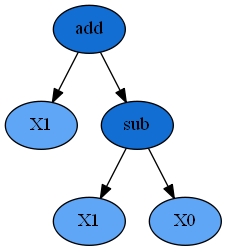

In [38]:
graph = pydotplus.graphviz.graph_from_dot_data(est._program.export_graphviz())
Image(graph.create_png())